In [1]:
from discopy.circuit import *
from discopy import *
import numpy as np

In [2]:
s , n = Ty('s'), Ty('n')

In [3]:
Alice = Word('Alice', n) 
Bob = Word('Bob', n) 
loves = Word('loves', n.r @ s @ n.l)

In [4]:
grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

In [5]:
sentences = [Alice @ loves @ Bob >> grammar, Bob @ loves @ Alice >> grammar]

In [6]:
loves_box = Box('loves', n, s @ n.l)
Bob_box = Box('Bob', n.l, Ty())

loves_ansatz = Cap(n.r, n) >> Id(n.r) @ Box('loves', n, s @ n.l)
Bob_transpose = Cap(n, n.l) >> Id(n) @ Box('Bob', n.l, Ty())

A = RigidFunctor(ob={s: s, n: n},
                 ar={Alice: Alice, Bob: Bob_transpose, loves: loves_ansatz})


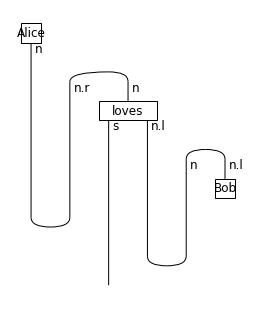

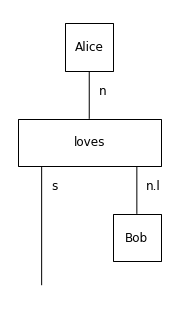

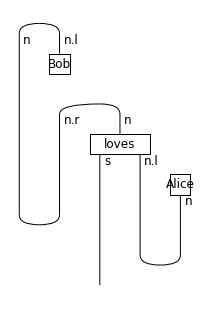

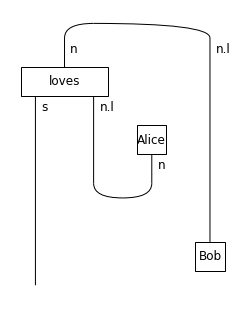

In [7]:
for sentence in sentences:
    A(sentence).draw(); A(sentence).normal_form().draw()

In [8]:
F = lambda params: CircuitFunctor(
    ob={s : 0, n: 1},
    ar={Alice: Ket(0), loves_box: Rz(params[0]) >> Rx(params[1]) >> H >>  Rz(params[2]) >> Rx(params[3]), Bob_box: Bra(1)})

In [9]:
#outputs circuit of sentencence in normal form with given parameters
C = lambda sentence, params: F(params)(A(sentence).normal_form())

In [10]:
#loss of a circuit with given parameters with respect to the label of the sentence it represents
#label is a 0/1 truth value and measuring the circuit gives a scalar in [0,1];
#this is the case where sentence space is scalar s=0
Loss = lambda circuit, label : (circuit.measure()-label)**2

In [11]:
#loss of many sentences as mean of losses of each sentence
Loss_text = lambda sentences, labels, params: sum([Loss(C(sentences[x],params),labels[x]) for x in range(len(sentences))])/len(sentences)

In [12]:
#assume the parameters are phases
#two updates for different phase rotations
def update_param_plus(p, dp = 0.01):
    p = p + dp
    return p
def update_param_minus(p, dp = 0.01):
    p = p - dp
    return p

In [13]:
def train(sentence, label, params, threshold = 0.01):
    
    #construct circuit and get loss from given sentence
    circuit = C(sentence, params)
    loss = Loss(circuit, label)
    
    while loss > threshold:
    #optimise params of sentence such that loss of its circuit is below threshold
        
        for pp, param in enumerate(params):
            
            #for each parameter, in series do:
            #try a counter-clock-wise phase rotation
            #check if loss decreased:
            #if yes, update the param
            #if no, do clock-wise update
            #check again if loss decreased:
            #if yes, update the param
            #if no, do nothing and go to the next parameter
            
            tempparam = update_param_plus(param)
            tempparams = params
            tempparams[pp] = tempparam 
            tempcircuit = C(sentence, tempparams)
            temploss = Loss(tempcircuit, label)
            
            if temploss < loss:
                
                params[pp] = tempparam 
                loss = temploss
            
            else:
                
                tempparam = update_param_minus(param)
                tempparams = params
                tempparams[pp] = tempparam 
                tempcircuit = C(sentence, tempparams)
                temploss = Loss(tempcircuit, label)
                
                if temploss < loss:
                    
                    params[pp] = tempparam 
                    loss = temploss
    
    return params, loss

In [14]:
def train_text(sentences, labels, params, threshold = 0.05):
    # loop over sentences and train params for each one in series
    
    loss_text = Loss_text(sentences, labels, params)
    
    while loss_text > threshold:
    
        for x in range(len(sentences)):
            
            params = train(sentences[x], labels[x], params)[0]
            loss_text = Loss_text(sentences, labels, params)
            
    return params, loss_text

In [15]:
#test that training one sentence works
labels = [1,0] # choose some true/false labels for each sentence

params = np.random.rand(4) # initialise random parameters

sentidx = 1 #chose a sentence (by its index in the list "sentences")
train(sentences[sentidx], labels[sentidx], params)

(array([0.17507712, 0.28241894, 0.87540412, 0.21257116]),
 DeviceArray(0.00865988, dtype=float32))

In [16]:
#test that training two sentences (i.e. text) works

labels = [1,1] # choose some true/false labels for each sentence
#You cannot choose [1,0] for this because training never terminate if we're using only one qubit!

params = np.random.rand(4) # initialise random parameters

params = train_text(sentences, labels, params)[0]

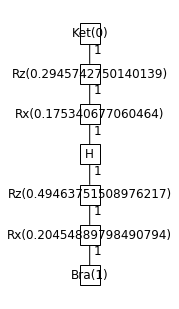

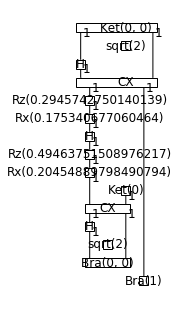

In [17]:
#draw the circuits for sentences with the optimal parameters
for sentence in sentences:
    circuit = C(sentence, params)
    circuit.draw()